# Summary
___
This notebook describes **4 experiments** in **3 categories**:

| **Experiement** | **Target** | **Comparative Models** | **Are models finetuned** | **Brief** | 
|---|---|---|---|---|
|[Computational Complexity Analysis](#Computational-Complexity-Analysis)| Compare computational complexity between scaling approach on long input | BART, BigBird (multiple configurations), MCA | No | Increase input length and measure the Time and Memory footprint of each model. |
|[**MEDIQA-AnS**](#MEDIQA-AnS)| Measure how MCA and PMC contribute to a certain abstractive MDS task | BART, MCA, other Non-finetuned models | Yes | Fair comparison between BART vs MCA vs MCA+PMC under same **tuning conditions**. Analysis component contribution, improvement and limitation. |
|[DUC2004](#DUC2004), [MLSR-cochrane](#MLSR-cochrane-(validation-set))| Measure how MCA contribute to a certain abstractive MDS task on non-finetuned BART model | BART, MCA, BigBird, PEGASUS | No | Compare model performance on DUC2004 task-2 data and MLSR-cochrane-validation data. All non-finetuned comparative models achieve SOTA results on SOTA benchmark. |


Mentioned datasets statistics:

<!-- | Statistic aspect                        | MEDIQA-AnS (test set) | DUC-2004 (task 2) |
|----------------------------------------|-----------------------|-------------------|
| Number of sample                        | 80                    | 50                |
| Sentence / abstractive summary          | 5.23                  | 6.59              |
| Word / abstractive summary              | 84.29                 | 120.14            |
| Abstractive compress ratio              | 0.15                  | 0.02              |
| Sentence / multi-document               | 57.41                 | 265.3             |
| Word / multi-document                   | 913.05                | 6911.0            |
| Sentence / question                     | 1.00                  | \_                |
| Word / question                         | 9.03                  | \_                |
| Single-document / multi-document        | 3.79                  | 10.0              |
| Word / single-document                  | 241.07                | 691.1             |
| Sentence / single-document              | 15.16                 | 26.53             | -->


In [2]:
%%capture
from datasets import load_dataset
import pandas as pd
from tqdm.auto import tqdm

# Load the Hugging Face datasets
dataset_a = load_dataset("nbtpj/BioNLP2021")['test']
dataset_b = load_dataset("nbtpj/DUC2004")['train']
dataset_c = load_dataset("allenai/mslr2022", 'cochrane')['validation']

import re

def split_sentences(text):
    if '<SS>' in text:
        return text.split('<SS>')
    sentence_regex = r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s'
    sentences = re.split(sentence_regex, text)
    return sentences

def split_words(sentence):
    if '<SS>' in sentence:
        sentence = sentence.replace('<SS>', ' ')
    word_regex = r'\W+'
    words = re.split(word_regex, sentence)
    return words

def calculate_average_lengths(dataset, text_column="text", target_column="target"):
    num_rows = len(dataset)
    num_multi_docs = 0
    total_single_doc_sentences, a1 = 0, 0
    total_single_doc_words, a2 = 0, 0
    total_multi_doc_sentences, a3 = 0, 0
    total_multi_doc_words, a4 = 0, 0
    total_target_sentences, a5 = 0, 0
    total_target_words, a6 = 0, 0

    for row in tqdm(dataset, f'Processing dataset'):
        a3 += 1
        a4 += 1
        multi_doc_sentences = 0
        multi_doc_words = 0
        single_doc_list = row[text_column] if '<DOC>' not in row[text_column] else row[text_column].split('<DOC>')
        target_list = row[target_column] if isinstance(row[target_column], list) else [row[target_column]]

        # Average number of single documents per multi-document
        if len(single_doc_list) > 1:
            num_multi_docs += len(single_doc_list)
        

        # Average single document length in sentences and words
        for doc in single_doc_list:
            a1 += 1
            a2 += 1
            doc_sentences = len(split_sentences(doc))
            doc_words = len(split_words(doc)) 
            total_single_doc_sentences += doc_sentences
            multi_doc_sentences+= doc_sentences
            total_single_doc_words += doc_words
            multi_doc_words+= doc_words

        total_multi_doc_sentences += multi_doc_sentences
        total_multi_doc_words += multi_doc_words

        # Average target length in sentences and words
        for target in target_list:
            a5 += 1
            a6 += 1
            target_sentences = len(split_sentences(target))
            target_words = len(split_words(target)) 
            total_target_sentences += target_sentences
            total_target_words += target_words

    average_single_doc_per_multi_doc = num_multi_docs / num_rows
    average_single_doc_sentence_length = total_single_doc_sentences / a1
    average_single_doc_word_length = total_single_doc_words / a2
    average_multi_doc_sentence_length = total_multi_doc_sentences / a3
    average_multi_doc_word_length = total_multi_doc_words / a4
    average_target_sentence_length = total_target_sentences / a5
    average_target_word_length = total_target_words / a6

    return (average_single_doc_per_multi_doc, average_single_doc_sentence_length, average_single_doc_word_length,
            average_multi_doc_sentence_length, average_multi_doc_word_length, average_target_sentence_length,
            average_target_word_length)

# Calculate average lengths for each dataset
avg_single_doc_per_multi_a, avg_single_doc_sent_len_a, avg_single_doc_word_len_a, avg_multi_doc_sent_len_a, \
avg_multi_doc_word_len_a, avg_target_sent_len_a, avg_target_word_len_a = calculate_average_lengths(dataset_a,text_column="text", target_column="summ_abs")

avg_single_doc_per_multi_b, avg_single_doc_sent_len_b, avg_single_doc_word_len_b, avg_multi_doc_sent_len_b, \
avg_multi_doc_word_len_b, avg_target_sent_len_b, avg_target_word_len_b = calculate_average_lengths(dataset_b,text_column="context", target_column="summary")

avg_single_doc_per_multi_c, avg_single_doc_sent_len_c, avg_single_doc_word_len_c, avg_multi_doc_sent_len_c, \
avg_multi_doc_word_len_c, avg_target_sent_len_c, avg_target_word_len_c = calculate_average_lengths(dataset_c,text_column="abstract", target_column="target")

# Create a DataFrame with the results
data = {
    'Dataset': ['BioNLP2021', 'DUC2004', 'MSLR-cochrane'],
    'Number of Example': [len(dataset_a), len(dataset_b), len(dataset_c)],
    'Avg Single Doc per Multi-Doc': [avg_single_doc_per_multi_a, avg_single_doc_per_multi_b, avg_single_doc_per_multi_c],
    'Avg Single Doc Sentence Length': [avg_single_doc_sent_len_a, avg_single_doc_sent_len_b, avg_single_doc_sent_len_c],
    'Avg Single Doc Word Length': [avg_single_doc_word_len_a, avg_single_doc_word_len_b, avg_single_doc_word_len_c],
    'Avg Multi-Doc Sentence Length': [avg_multi_doc_sent_len_a, avg_multi_doc_sent_len_b, avg_multi_doc_sent_len_c],
    'Avg Multi-Doc Word Length': [avg_multi_doc_word_len_a, avg_multi_doc_word_len_b, avg_multi_doc_word_len_c],
    'Avg Target Sentence Length': [avg_target_sent_len_a, avg_target_sent_len_b, avg_target_sent_len_c],
    'Avg Target Word Length': [avg_target_word_len_a, avg_target_word_len_b, avg_target_word_len_c]
}

df = pd.DataFrame(data)

In [3]:
df.transpose()

,0,1,2
Dataset,BioNLP2021,DUC2004,MSLR-cochrane
Number of Example,80,50,470
Avg Single Doc per Multi-Doc,3.7875,10.0,10.6
Avg Single Doc Sentence Length,15.161716,26.232,9.666998
Avg Single Doc Word Length,244.39604,607.136,220.151798
Avg Multi-Doc Sentence Length,57.425,262.32,103.519149
Avg Multi-Doc Word Length,925.65,6071.36,2357.497872
Avg Target Sentence Length,5.225,7.88,3.197872
Avg Target Word Length,85.7875,108.415,72.282979


# Computational Complexity Analysis
___

## Experiment Details

1. Comparative models:

| Configuration | BART | MCA | BigBird |
|---------------|------|-----|---------|
| Embedding dimension ($d_{model}$) | 192 | 192 | 192 |
| Encoder/decoder attention head ($head$) | 3 | 3 | 3 |
| Encoder/decoder feedforward dimension ($d_{ff}$) | 768 | 768 | 768 |
| Number of encoder/decoder layers ($l_{enc}; l_{dec}$) | 1 | 1 | 1 |
| Max position embedding ($d_{max\_length}$) | 16384 | 16384 | 16384 |
| Vocabulary size ($d_{vocab}$) | 200 | 200 | 200 |
| Sparse block size | \_ | \_ | [16, 32, 64] |
| Number of parameters | 7,369,728 | 7,369,728 | 7,366,656 |


2. Length-increasing simulation:

Each Multi-document contain multiples single document. 
Each single document has same length of $256$ tokens, and the simulation targets to simulate the increament in the number of document.
In more detailed, it is expanded in 2 ways:

- Vertical Scaling (MCA): Increase cummulatively in the channel dimension of the input. (input shape: \[batch_size x n_channel x seq_length\])
- Horizontal Scaling (BART, BigBird): Increase cummulatively in the sequence dimension of the input. (input shape: \[batch_size  x seq_length\])

## Results

Fig: Computing cost comparison.

In [6]:
!python3 run_complex_analysis.py

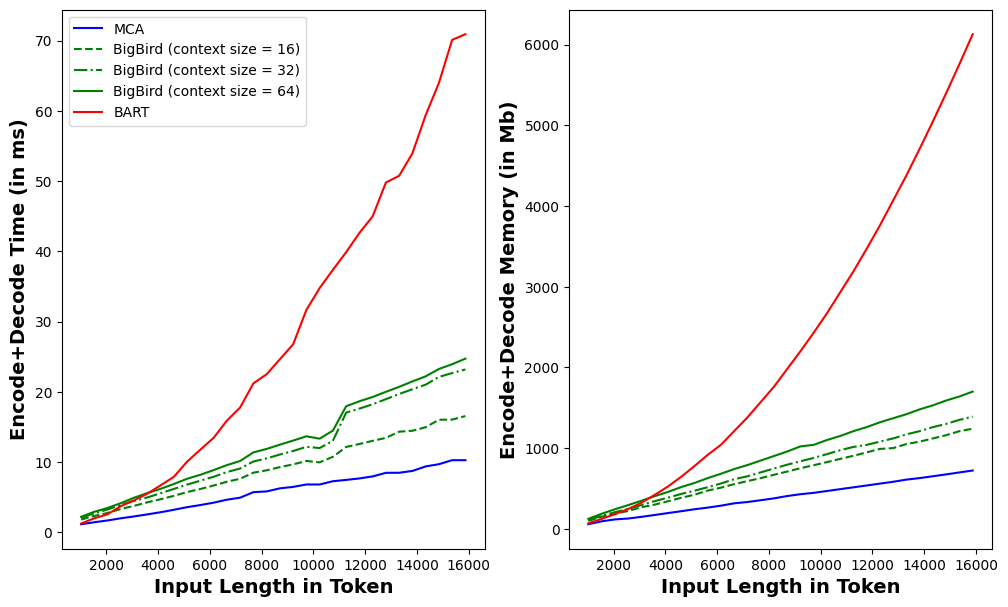

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams["font.weight"] = "normal"
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.labelsize"] = 14

params = {'mathtext.default': 'regular'}
plt.rcParams.update(params)

encode_decode = pd.read_csv('./documents/encode-decode-time-mem.csv')
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12,7), sharex=True)
target_tab = encode_decode.sort_values(by='Input Length in Token')
model_name_map = {
    'mca_model': 'MCA',
    'bart_model': 'BART',
    'bigbird_model_16': 'BigBird (context size = 16)',
    'bigbird_model_32': 'BigBird (context size = 32)',
    'bigbird_model_64': 'BigBird (context size = 64)',
}
label_map = {
    'CUDA time avg in ms': 'Encode+Decode Time (in ms)',
    'Self CUDA Mem in Mb': 'Encode+Decode Memory (in Mb)'
}
colors = {
    'mca_model': 'blue',
    'bart_model': 'red',
    'bigbird_model_16': 'green',
    'bigbird_model_32': 'green',
    'bigbird_model_64': 'green',
}
for name, ax in zip(['CUDA time avg in ms', 'Self CUDA Mem in Mb'], [ax1, ax2]):
    
    ax.set(ylabel=label_map[name])
    for i, model_name in enumerate(target_tab['Name'].unique()):
        df = target_tab[target_tab['Name']==model_name]
        if '16' in model_name:
            ax.plot(df['Input Length in Token'], df[name],'--', label=model_name_map[model_name], color=colors[model_name])
        elif '32' in model_name:
            ax.plot(df['Input Length in Token'], df[name],'-.', label=model_name_map[model_name], color=colors[model_name])
        else:
            ax.plot(df['Input Length in Token'], df[name], label=model_name_map[model_name], color=colors[model_name])

            
ax1.legend()
ax1.set(xlabel='Input Length in Token')
ax2.set(xlabel='Input Length in Token')
fig.savefig(f'./documents/encoder-decoder.pdf')
fig.savefig(f'./documents/encoder-decoder.png')

# MEDIQA AnS
___

## Experiment Details

1. Comparative models

(We reported on the trained models. For the training code, refer to the code provided in the [README](../README.md) example)


| Configuration | BART-large (BART-large+MCA) | BART-base (MCA+PMC, BART+PMC, BART) | distil-BART (distil-BART+ MCA) | PEGASUS | BigBird |
| --- | --- | --- | --- | --- | --- |
| Embedding dimension ($d_{model}$) | 1024 | 768 | 1024 | 1024 | 1024 |
| Encoder attention head ($head$) | 16 | 12 | 16 | 16 | 16 |
| Decoder attention head ($head$) | 16 | 12 | 16 | 16 | 16 |
| Encoder feedforward dimension ($d_{ff}$) | 4096 | 3072 | 4096 | 4096 | 4096 |
| Decoder feedforward dimension ($d_{ff}$) | 4096 | 3072 | 4096 | 4096 | 4096 |
| Number of encoder layers ($l\_enc$) | 12 | 6 | 6 | 16 | 16 |
| Number of decoder layers ($l\_dec$) | 12 | 6 | 6 | 16 | 16 |
| Max position embedding ($d\_{max\_length}$) | 1024 | 1024 | 1024 | 1024 | 4096 |
| Vocabulary size ($d_{vocab}$) | 50264 | 50265 | 50264 | 96103 | 96103 |
| Sparse block size | \_ | \_ | \_ | \_ | 64 |
| Number of parameters (in million) | 406.3 | 139.4 | 229.9 | 570.8 | 576.9 |
| Huggingface repository | facebook/bart-large-cnn | facebook/bart-base | sshleifer/distilbar-cnn-6-6 | google/pegasus-cnn_dailymail | google/bigbird-pegasus-large-bigpatent |


In [5]:
# reproduce experimental results on the MEDIQA-AnS by these codes

import sys

# Open a file to save the log
log_file = open('log_run_mediqa_ans.txt', 'w+')

# Redirect standard output to the log file
sys.stdout = log_file
!python3 run_MEDIQA_AnS.py --batch_size 1

# Close the log file
log_file.close()

! cd ../ && git add .
!git commit -m "update cached files"
!git push

# Restore standard output
sys.stdout = sys.__stdout__

2. Multi-length-range generative configuration test

**Comparative models :**
* BART (non-finetuned)
* BART
* BART + PMC
* MCA + PMC

On same tuning conditions, test on BioNLP2021 test subset.

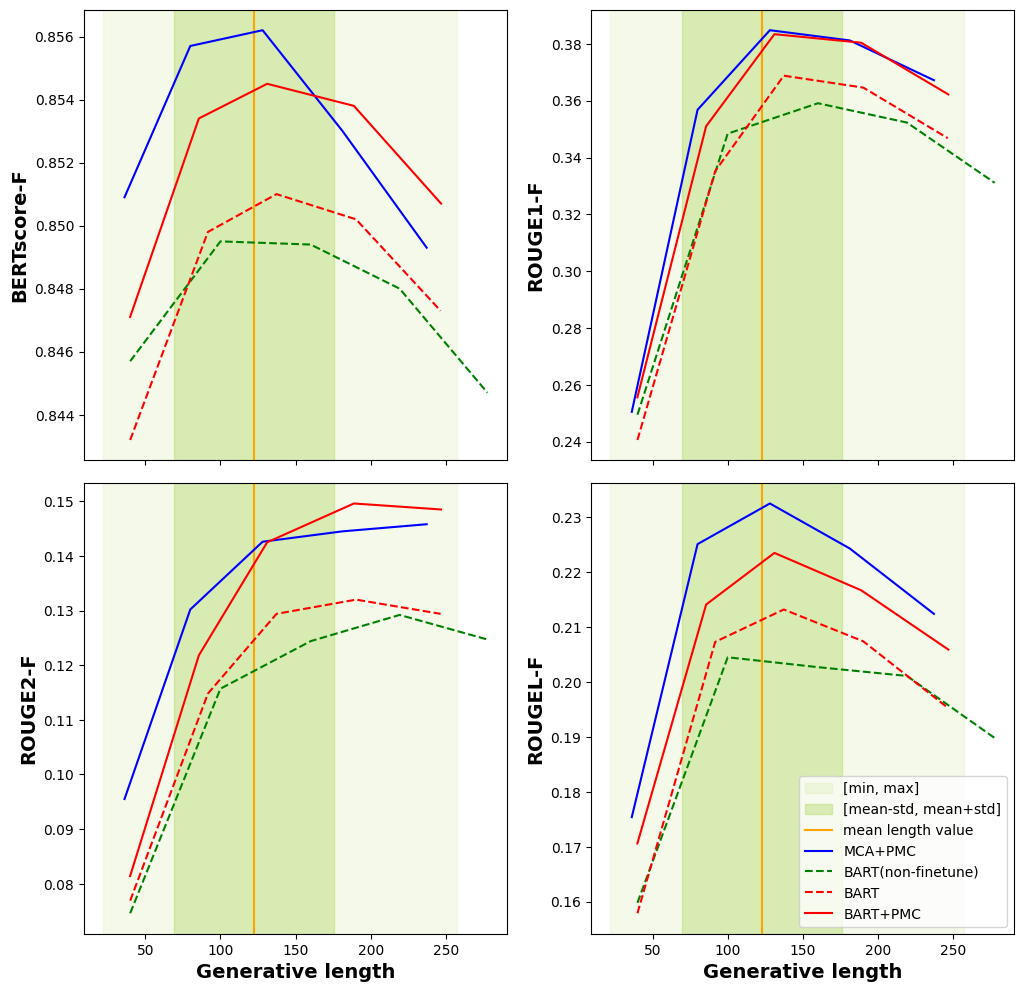

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12), sharex=True)
plt.subplots_adjust(hspace=0.05)  # Adjust vertical spacing
plt.subplots_adjust(wspace=0.2)  # Adjust horizontal spacing
lines, labels = [], []


import pickle
with open('./documents/MEDIQA-AnS-scores.pk', 'rb') as f:
    (des, statistics_by_model, model_name_map) = pickle.load(f)
max_length = des['max']
min_length = des['min']
mean_length = des['mean']
std = des['std']

to_visual_name_map = {
    k:v for k, v in model_name_map.items() if v in ['MCA+PMC', 'BART', 'BART+PMC', 'BART(non-finetune)']
}

to_visual_colors = {
    'nbtpj/mc-bart-base-mqa-fine-tune':'blue',
    'nbtpj/bart-base-mqa-fine-tune-non-mca':'red',
    'nbtpj/bart-base-rmqa-fine-tune-non-mca':'red',
    'facebook/bart-base-non-mca': 'green'
}
aspects = {
    'avg-rouge1-fmeasure': 'ROUGE1-F',
    'avg-rouge2-fmeasure': 'ROUGE2-F',
    'avg-rougeL-fmeasure': 'ROUGEL-F',
    'avg-bert-f1': 'BERTscore-F',
}

for aspect, ax in zip(['avg-bert-f1', 'avg-rouge1-fmeasure', 'avg-rouge2-fmeasure', 'avg-rougeL-fmeasure'], [ax1, ax2, ax3, ax4]):
    ax.axvspan(min_length, max_length, alpha=0.1, label='[min, max]', color='yellowgreen' )
    ax.axvspan(mean_length-std, mean_length+std, alpha=0.3, label='[mean-std, mean+std]', color='yellowgreen')
    ax.axvline(mean_length, color='orange', label='mean length value')
    ax.set(ylabel=aspects[aspect])
    for model_name, df in statistics_by_model.items():
        if model_name in to_visual_name_map:
            if 'rmqa' not in model_name and 'mc-' not in model_name:
                ax.plot(df['gen_len'], df[aspect], '--', label=model_name_map[model_name], color=to_visual_colors[model_name])
            else:
                ax.plot(df['gen_len'], df[aspect], label=model_name_map[model_name], color=to_visual_colors[model_name])
            
ax4.legend()
ax3.set(xlabel='Generative length')
ax4.set(xlabel='Generative length')
fig.savefig(f'./documents/multi-range-MEDIQA-AnS.pdf')
fig.savefig(f'./documents/multi-range-MEDIQA-AnS.png')

## Fixed-length setting summary
**Summary table (In the order of R2F decreased)**


All models (finetuned and non-finetuned), the generative length is fixed (100-160 tokens/ example)

In [7]:
import pandas as pd

MEDIQA_model_name_map = model_name_map
MEDIQA_full_fixed = pd.read_csv('./documents/MEDIQA-AnS-full-fixed-setting.csv')
MEDIQA_full_fixed.rename(columns={'Unnamed: 0':'Model'}, inplace=True)
MEDIQA_full_fixed['Model'] = MEDIQA_full_fixed['Model'].map(lambda x: MEDIQA_model_name_map[x] if x in MEDIQA_model_name_map else x)
MEDIQA_full_fixed.sort_values('avg-rouge2-fmeasure', ascending=False, inplace=True)
MEDIQA_full_fixed

,Model,expected_len,avg-rouge1-precision,avg-rouge1-recall,avg-rouge1-fmeasure,avg-rouge2-precision,avg-rouge2-recall,avg-rouge2-fmeasure,avg-rougeL-precision,avg-rougeL-recall,avg-rougeL-fmeasure,avg-bert-precision,avg-bert-recall,avg-bert-f1,gen_len,overflow_ratio
2,MCA+PMC,122.6125,0.3782,0.4444,0.3848,0.1393,0.1694,0.1426,0.2267,0.2735,0.2325,0.8597,0.8533,0.8562,128.0500,0.0294
12,BART+PMC,122.6125,0.3720,0.4447,0.3834,0.1402,0.1646,0.1425,0.2159,0.2634,0.2235,0.8575,0.8520,0.8545,131.0750,0.1405
11,BART,122.6125,0.3518,0.4391,0.3688,0.1237,0.1582,0.1294,0.2016,0.2591,0.2132,0.8532,0.8493,0.8510,137.3000,0.1405
8,BART-large without query,122.6125,0.3577,0.4255,0.3645,0.1222,0.1515,0.1250,0.2035,0.2541,0.2104,0.8575,0.8503,0.8536,129.1250,0.1377
9,BART-large with query,122.6125,0.3741,0.4212,0.3718,0.1255,0.1484,0.1247,0.2107,0.2460,0.2108,0.8601,0.8501,0.8548,122.0750,0.1402
5,BART(non-finetune),122.6125,0.3190,0.4652,0.3591,0.1106,0.1666,0.1244,0.1783,0.2699,0.2027,0.8494,0.8499,0.8494,160.0000,0.1402
15,PEGASUS with query,117.1250,0.3608,0.3882,0.3521,0.1282,0.1350,0.1226,0.2106,0.2326,0.2070,0.8635,0.8648,0.8640,112.8875,0.1283
13,PEGASUS without query,117.1250,0.3600,0.3828,0.3494,0.1227,0.1300,0.1176,0.2078,0.2304,0.2040,0.8617,0.8634,0.8623,112.4125,0.1261
6,distil-BART without query,122.6125,0.3673,0.3544,0.3393,0.1176,0.1175,0.1087,0.2079,0.2076,0.1940,0.8590,0.8395,0.8489,101.0375,0.1377
7,distil-BART with query,122.6125,0.3683,0.3607,0.3421,0.1154,0.1160,0.1066,0.2104,0.2130,0.1971,0.8606,0.8392,0.8495,101.0250,0.1402


## Cummulative contribution (fixed length setting)
**Use 4 benchmark results of BART(non-finetuned) -> BART -> BART + PMC -> MCA + PMC**

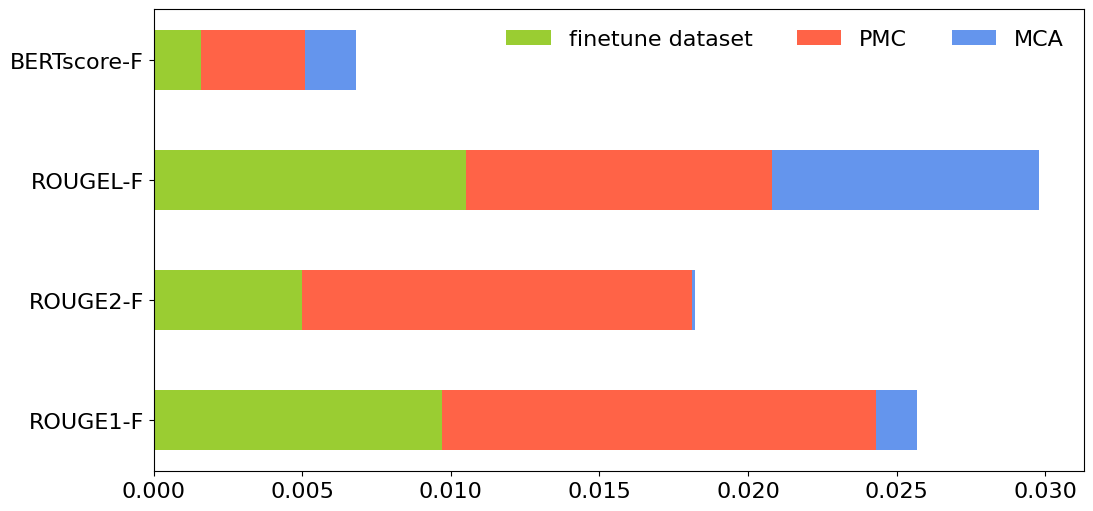

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['ytick.minor.right'] = False

mpl.rcParams["font.weight"] = "normal"
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.labelsize"] = 24

params = {'mathtext.default': 'regular'}
plt.rcParams.update(params)

components = {
    'MCA': ('MCA+PMC','BART+PMC'),
    'PMC': ('BART+PMC','BART'),
    'finetune dataset': ('BART','BART(non-finetune)'),
}
scale = ('MCA+PMC','BART(non-finetune)')
aspects = {
    'avg-rouge1-fmeasure': 'ROUGE1-F',
    'avg-rouge2-fmeasure': 'ROUGE2-F',
    'avg-rougeL-fmeasure': 'ROUGEL-F',
    'avg-bert-f1': 'BERTscore-F',
}

contributions = {}
for component, (b, e) in components.items():
    contributions[component] = {}
    for aspect, aspect_name in aspects.items():
        contributions[component][aspect_name] = MEDIQA_full_fixed[MEDIQA_full_fixed['Model']==b][aspect].values[0] - MEDIQA_full_fixed[MEDIQA_full_fixed['Model']==e][aspect].values[0]
contributions = pd.DataFrame(contributions)


width = 0.5       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots(figsize=(12,6))
colors = iter(['yellowgreen', 'tomato','cornflowerblue', ])
last = np.zeros((contributions.shape[0],))
for clm in ['finetune dataset', 'PMC', 'MCA']:
    ax.barh(list(contributions.index), contributions[clm], left=last,height=width, label=clm, color=next(colors))
    last += contributions[clm]

ax.legend(ncol=3, frameon=False,prop={'size': 16})
fig.savefig(f'./documents/cummulative-fixed-component-contribution-MEDIQA-AnS.pdf')
fig.savefig(f'./documents/cummulative-fixed-component-contribution-MEDIQA-AnS.png')
plt.show()

## Adaptive-length setting summary
**Summary Table (In the order of R2F decreased)**

All models (finetuned and non-finetuned), the generative length is dynamic (depend on golden length +- 10 tokens)

In [12]:
import pandas as pd

MEDIQA_model_name_map = model_name_map
MEDIQA_full_adaptive = pd.read_csv('./documents/MEDIQA-AnS-full-adaptive-setting.csv')
MEDIQA_full_adaptive.rename(columns={'Unnamed: 0':'Model'}, inplace=True)
MEDIQA_full_adaptive['Model'] = MEDIQA_full_fixed['Model'].map(lambda x: MEDIQA_model_name_map[x] if x in MEDIQA_model_name_map else x)
MEDIQA_full_adaptive.sort_values('avg-rouge2-fmeasure', ascending=False, inplace=True)
MEDIQA_full_adaptive

,Model,expected_len,avg-rouge1-precision,avg-rouge1-recall,avg-rouge1-fmeasure,avg-rouge2-precision,avg-rouge2-recall,avg-rouge2-fmeasure,avg-rougeL-precision,avg-rougeL-recall,avg-rougeL-fmeasure,avg-bert-precision,avg-bert-recall,avg-bert-f1,gen_len,overflow_ratio
2,MCA+PMC,122.6125,0.3984,0.4130,0.4041,0.1455,0.1506,0.1474,0.2426,0.2519,0.2462,0.8644,0.8515,0.8578,120.0250,0.0294
12,BART+PMC,122.6125,0.3955,0.4128,0.4025,0.1426,0.1493,0.1453,0.2276,0.2384,0.2319,0.8619,0.8503,0.8560,120.7750,0.1405
11,BART,122.6125,0.3667,0.3921,0.3777,0.1231,0.1333,0.1274,0.2142,0.2312,0.2215,0.8567,0.8458,0.8511,122.3625,0.1405
8,BART-large without query,122.6125,0.3691,0.3861,0.3755,0.1243,0.1316,0.1270,0.2130,0.2260,0.2179,0.8602,0.8476,0.8538,120.0500,0.1377
5,BART(non-finetune),122.6125,0.3620,0.3876,0.3729,0.1203,0.1306,0.1247,0.2087,0.2243,0.2153,0.8565,0.8457,0.8510,124.1000,0.1402
9,BART-large with query,122.6125,0.3696,0.3861,0.3757,0.1170,0.1224,0.1189,0.2065,0.2179,0.2107,0.8594,0.8472,0.8532,120.1250,0.1402
13,PEGASUS without query,117.1250,0.3695,0.3456,0.3554,0.1228,0.1165,0.1188,0.2119,0.2015,0.2053,0.8644,0.8614,0.8628,104.6875,0.1261
15,PEGASUS with query,117.1250,0.3665,0.3429,0.3527,0.1201,0.1132,0.1159,0.2115,0.1997,0.2043,0.8636,0.8595,0.8615,105.0500,0.1283
6,distil-BART without query,122.6125,0.3622,0.3583,0.3582,0.1133,0.1133,0.1125,0.2083,0.2079,0.2067,0.8573,0.8398,0.8484,112.4750,0.1377
7,distil-BART with query,122.6125,0.3629,0.3620,0.3602,0.1081,0.1089,0.1076,0.2058,0.2075,0.2052,0.8593,0.8401,0.8495,112.7375,0.1402


## Cummulative contribution (adaptive length setting)
**Use 4 benchmark results of BART(non-finetuned) -> BART -> BART + PMC -> MCA + PMC**

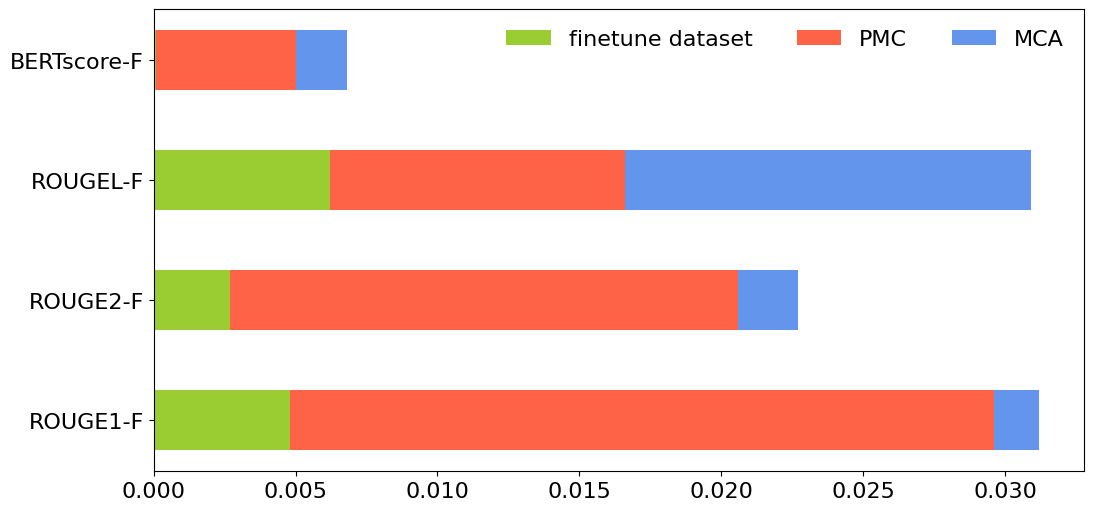

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

components = {
    'MCA': ('MCA+PMC','BART+PMC'),
    'PMC': ('BART+PMC','BART'),
    'finetune dataset': ('BART','BART(non-finetune)'),
}
scale = ('MCA+PMC','BART(non-finetune)')
aspects = {
    'avg-rouge1-fmeasure': 'ROUGE1-F',
    'avg-rouge2-fmeasure': 'ROUGE2-F',
    'avg-rougeL-fmeasure': 'ROUGEL-F',
    'avg-bert-f1': 'BERTscore-F',
}

contributions = {}
for component, (b, e) in components.items():
    contributions[component] = {}
    for aspect, aspect_name in aspects.items():
        contributions[component][aspect_name] = MEDIQA_full_adaptive[MEDIQA_full_adaptive['Model']==b][aspect].values[0] - MEDIQA_full_adaptive[MEDIQA_full_adaptive['Model']==e][aspect].values[0]
contributions = pd.DataFrame(contributions)


width = 0.5       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots(figsize=(12,6))
colors = iter(['yellowgreen', 'tomato','cornflowerblue', ])
last = np.zeros((contributions.shape[0],))
for clm in ['finetune dataset', 'PMC', 'MCA']:
    ax.barh(list(contributions.index), contributions[clm], left=last,height=width, label=clm, color=next(colors))
    last += contributions[clm]

ax.legend(ncol=3, frameon=False,prop={'size': 16})
fig.savefig(f'./documents/cummulative-adaptive-component-contribution-MEDIQA-AnS.pdf')
fig.savefig(f'./documents/cummulative-adaptive-component-contribution-MEDIQA-AnS.png')

plt.show()

# DUC2004
___
Is a dataset:
* General-purpose domain (article)
* 10 single-doc/each
* 4 golden/each

Comparative models achieved good results on CNN/DM:
<!-- \begin{table}[H]
\centering
\caption{The self-reported results of comparative models on CNN/DM benchmark. The current highest scores for each metric are bold.}
\label{tab:cnn-dm}
\begin{adjustbox}{width=0.55\columnwidth,center}
    \begin{tabular}{|l|ccc|}
\hline
\textbf{Model} &\textbf{ROUGE-1}&\textbf{ROUGE-2}&\textbf{ROUGE-L}\\
% \multicolumn{1}{|c|}{\textbf{Model}} & \textbf{\begin{tabular}[c]{@{}c@{}}ROUGE-1 \\ F1\end{tabular}} & \textbf{\begin{tabular}[c]{@{}c@{}}ROUGE-2 \\ F1\end{tabular}} & \textbf{\begin{tabular}[c|]{@{}c@{}}ROUGE-L \\ F1\end{tabular}} \\ 
\hline
distil-BART                        & \_                                                              & 20.17                                                          & 29.70                                                          \\
BART-large                         & 44.16                                                          & 21.28                                                          & 40.90                                                          \\
PEGASUS                            & 44.16                                                          & 24.56                                                          & 41.3                                                           \\
BigBird                            & 43.84                                                          & 21.11                                                          & 40.74                                                          \\
SOTA                               & \textbf{48.88}                                                 & \textbf{24.94}                                                 & \textbf{45.76}   \\ \hline                                 
\end{tabular}
\end{adjustbox}
\end{table} -->
| Model           | ROUGE-1 | ROUGE-2 | ROUGE-L |
|-----------------|---------|---------|---------|
| distil-BART     | -       | 20.17   | 29.70   |
| BART-large      | 44.16   | 21.28   | 40.90   |
| PEGASUS         | 44.16   | 24.56   | 41.3    |
| BigBird         | 43.84   | 21.11   | 40.74   |
| SOTA            | **48.88**   | **24.94**   | **45.76**   |

___
Detailed comparative models:

| Configuration | BART-large (BART-large+MCA) | BART-base (MCA+PMC, BART+PMC, BART) | distil-BART (distil-BART+ MCA) | PEGASUS | BigBird |
| --- | --- | --- | --- | --- | --- |
| Embedding dimension ($d_{model}$) | 1024 | 768 | 1024 | 1024 | 1024 |
| Encoder attention head ($head$) | 16 | 12 | 16 | 16 | 16 |
| Decoder attention head ($head$) | 16 | 12 | 16 | 16 | 16 |
| Encoder feedforward dimension ($d_{ff}$) | 4096 | 3072 | 4096 | 4096 | 4096 |
| Decoder feedforward dimension ($d_{ff}$) | 4096 | 3072 | 4096 | 4096 | 4096 |
| Number of encoder layers ($l\_enc$) | 12 | 6 | 6 | 16 | 16 |
| Number of decoder layers ($l\_dec$) | 12 | 6 | 6 | 16 | 16 |
| Max position embedding ($d\_{max\_length}$) | 1024 | 1024 | 1024 | 1024 | 4096 |
| Vocabulary size ($d_{vocab}$) | 50264 | 50265 | 50264 | 96103 | 96103 |
| Sparse block size | \_ | \_ | \_ | \_ | 64 |
| Number of parameters (in million) | 406.3 | 139.4 | 229.9 | 570.8 | 576.9 |
| Huggingface repository | facebook/bart-large-cnn | facebook/bart-base | sshleifer/distilbar-cnn-6-6 | google/pegasus-cnn_dailymail | google/bigbird-pegasus-large-bigpatent |



In [ ]:
# reproduce experimental results on the DUC2004 by these codes

import sys

# Open a file to save the log
log_file = open('log_run_duc2004_ans.txt', 'w+')

# Redirect standard output to the log file
sys.stdout = log_file
!python3 run_DUC2004.py --batch_size 1

# Close the log file
log_file.close()

# ! cd ../ && git add .
# !git commit -m "update cached files"
# !git push

# Restore standard output
sys.stdout = sys.__stdout__

## Averaged-pooling (mean score among 4 references) are shown


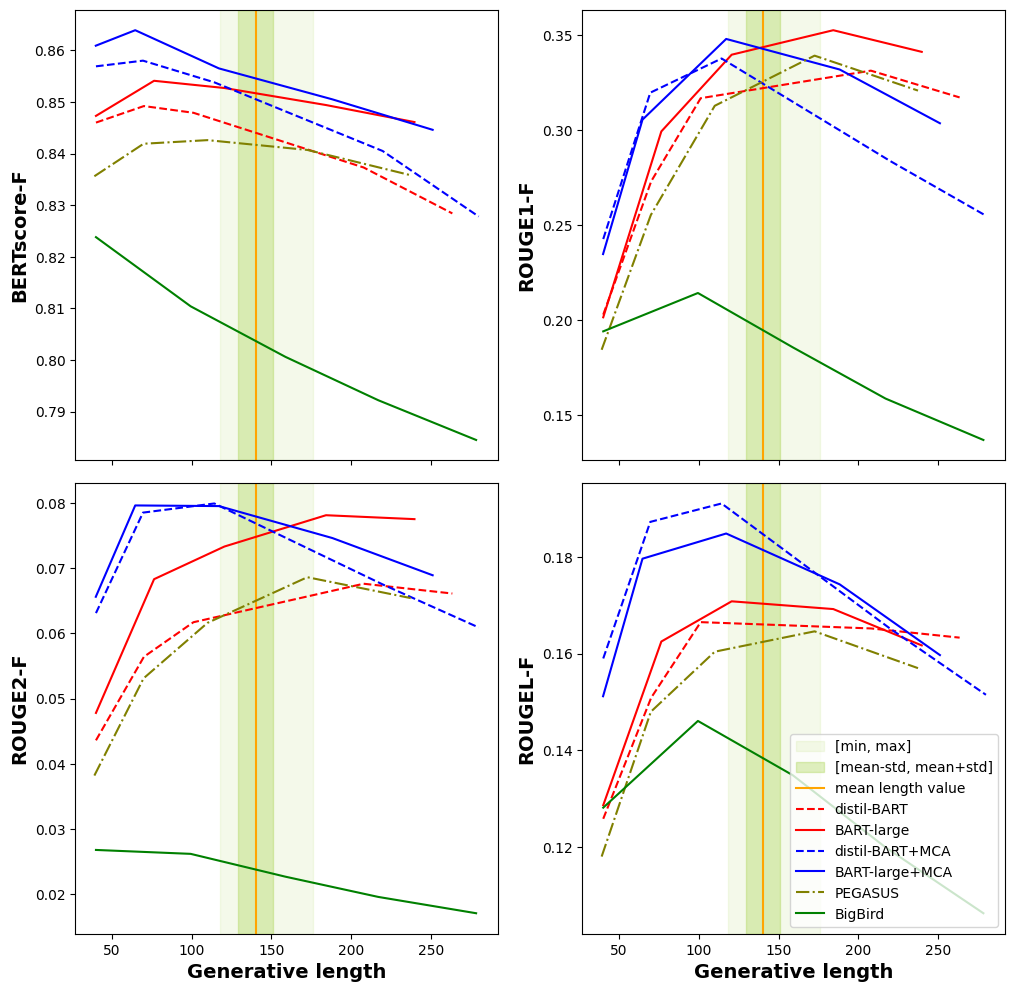

In [31]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12), sharex=True)
plt.subplots_adjust(hspace=0.05)  # Adjust vertical spacing
plt.subplots_adjust(wspace=0.2)  # Adjust horizontal spacing
lines, labels = [], []


mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams["font.weight"] = "normal"
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.labelsize"] = 14

params = {'mathtext.default': 'regular'}
plt.rcParams.update(params)

with open('./documents/DUC2004-scores.pk', 'rb') as f:
    (des, statistics_by_model, _) = pickle.load(f)
max_length = des['max']
min_length = des['min']
mean_length = des['mean']
std = des['std']

aspect_map = {
    'avg-bert-f1': 'BERTscore-F', 
    'avg-rouge1-fmeasure': 'ROUGE1-F', 
    'avg-rouge2-fmeasure': 'ROUGE2-F',
    'avg-rougeL-fmeasure': 'ROUGEL-F',
}

colors = {
    'sshleifer/distilbart-cnn-6-6': 'blue',
    'facebook/bart-large-cnn': 'blue',
    'sshleifer/distilbart-cnn-6-6-non-mca': 'red',
    'facebook/bart-large-cnn-non-mca': 'red',
    'google/pegasus-cnn_dailymail':'olive',
    'google/bigbird-pegasus-large-bigpatent': 'green'
}

revert_name = dict(zip(model_map_name.values(), model_map_name.keys()))

for aspect, ax in zip(['avg-bert-f1', 'avg-rouge1-fmeasure', 'avg-rouge2-fmeasure', 'avg-rougeL-fmeasure'], 
                      [ax1, ax2, ax3, ax4]):
    ax.axvspan(min_length, max_length, alpha=0.1, label='[min, max]', color='yellowgreen' )
    ax.axvspan(mean_length-std, mean_length+std, alpha=0.3, label='[mean-std, mean+std]', color='yellowgreen')
    ax.axvline(mean_length, color='orange', label='mean length value')
    ax.set(ylabel=aspect_map[aspect])
    for model_name, df in statistics_by_model.items():
        model_name = revert_name[model_name]
        if model_name in model_map_name:
            if 'distil' in model_map_name[model_name]:
                ax.plot(df['gen_len'], df[aspect],'--', label=model_map_name[model_name], color=colors[model_name])
            elif 'PEGASUS' in model_map_name[model_name]:
                ax.plot(df['gen_len'], df[aspect],'-.', label=model_map_name[model_name], color=colors[model_name])
            else:
                ax.plot(df['gen_len'], df[aspect], label=model_map_name[model_name], color=colors[model_name])
            
ax4.legend(loc='lower right')
ax3.set(xlabel='Generative length')
ax4.set(xlabel='Generative length')
fig.savefig(f'./documents/multi-range-duc-avg.pdf')
fig.savefig(f'./documents/multi-range-duc-avg.png')

In [21]:
model_map_name

{'sshleifer/distilbart-cnn-6-6': 'distil-BART+MCA',
 'facebook/bart-large-cnn': 'BART-large+MCA',
 'sshleifer/distilbart-cnn-6-6-non-mca': 'distil-BART',
 'facebook/bart-large-cnn-non-mca': 'BART-large',
 'google/pegasus-cnn_dailymail': 'PEGASUS',
 'google/bigbird-pegasus-large-bigpatent': 'BigBird'}

## Max-pooling (highest score among 4 references) are shown

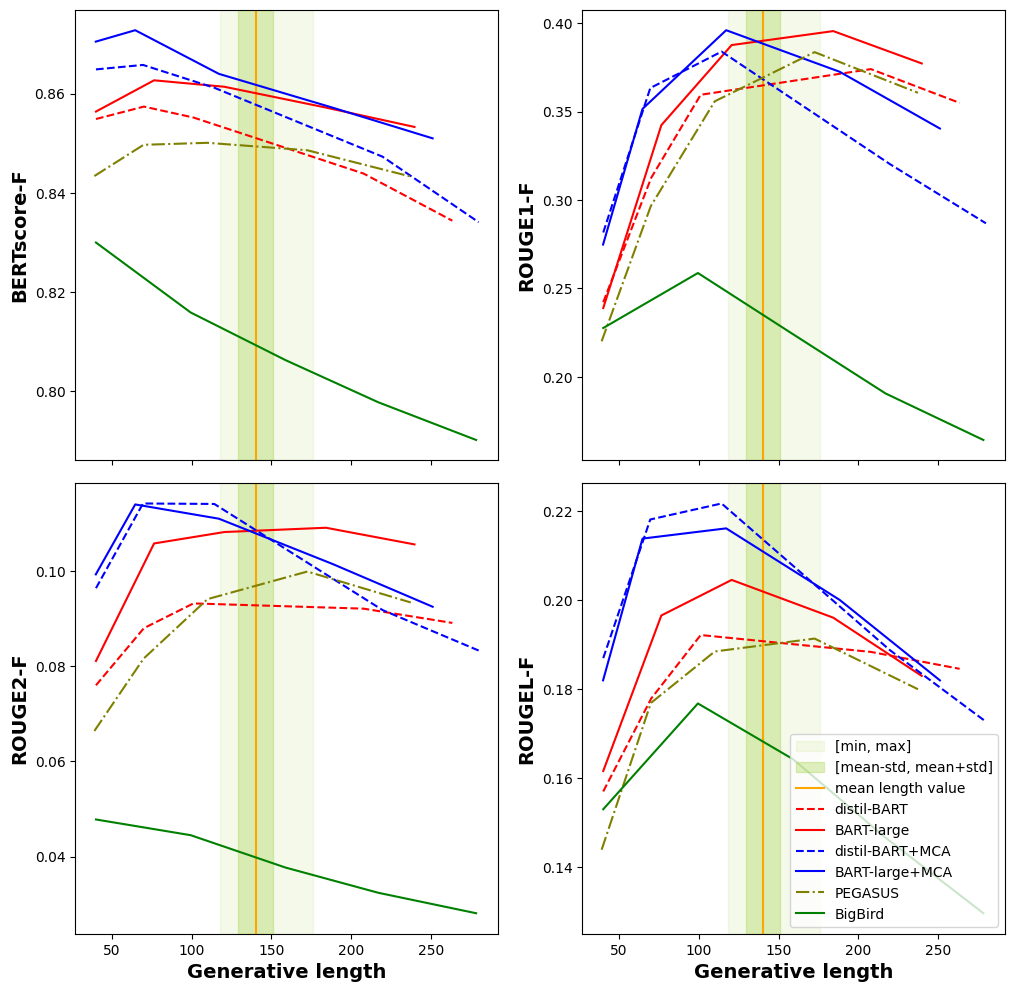

In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12), sharex=True)
plt.subplots_adjust(hspace=0.05)  # Adjust vertical spacing
plt.subplots_adjust(wspace=0.2)  # Adjust horizontal spacing
lines, labels = [], []

aspect_map = {
    'max-bert-f1': 'BERTscore-F', 
    'max-rouge1-fmeasure': 'ROUGE1-F', 
    'max-rouge2-fmeasure': 'ROUGE2-F',
    'max-rougeL-fmeasure': 'ROUGEL-F',
}

for aspect, ax in zip(['max-bert-f1', 'max-rouge1-fmeasure', 'max-rouge2-fmeasure', 'max-rougeL-fmeasure'], 
                      [ax1, ax2, ax3, ax4]):
    ax.axvspan(min_length, max_length, alpha=0.1, label='[min, max]', color='yellowgreen' )
    ax.axvspan(mean_length-std, mean_length+std, alpha=0.3, label='[mean-std, mean+std]', color='yellowgreen')
    ax.axvline(mean_length, color='orange', label='mean length value')
    ax.set(ylabel=aspect_map[aspect])
    for model_name, df in statistics_by_model.items():
        model_name = revert_name[model_name]
        if model_name in model_map_name:
            if 'distil' in model_name:
                ax.plot(df['gen_len'], df[aspect],'--', label=model_map_name[model_name], color=colors[model_name])
            elif '/pegasus' in model_name:
                ax.plot(df['gen_len'], df[aspect],'-.', label=model_map_name[model_name], color=colors[model_name])
            else:
                ax.plot(df['gen_len'], df[aspect], label=model_map_name[model_name], color=colors[model_name])
            
ax4.legend(loc='lower right')
ax3.set(xlabel='Generative length')
ax4.set(xlabel='Generative length')
fig.savefig(f'./documents/multi-range-duc-max.pdf')
fig.savefig(f'./documents/multi-range-duc-max.png')

## Fixed-length setting summary
**Summary table (In the order of R2F decreased)**


All models (finetuned and non-finetuned), the generative length is fixed (100-160 tokens/ example)

In [35]:
import pandas as pd

DUC2004_model_name_map = model_name_map
DUC2004_full_fixed = pd.read_csv('./documents/DUC2004-full-fixed-setting.csv')
DUC2004_full_fixed.rename(columns={'Unnamed: 0':'Model'}, inplace=True)
DUC2004_full_fixed['Model'] = DUC2004_full_fixed['Model'].map(lambda x: DUC2004_model_name_map[x] if x in DUC2004_model_name_map else x)
DUC2004_full_fixed.sort_values('avg-rouge2-fmeasure', ascending=False, inplace=True)
DUC2004_full_fixed

,Model,expected_len,max-rouge1-precision,max-rouge1-recall,max-rouge1-fmeasure,max-rouge2-precision,max-rouge2-recall,max-rouge2-fmeasure,max-rougeL-precision,max-rougeL-recall,...,avg-rougeL-recall,avg-rougeL-fmeasure,avg-bert-precision,avg-bert-recall,avg-bert-f1,max-bert-precision,max-bert-recall,max-bert-f1,gen_len,overflow_ratio
2,distil-BART+MCA,140.23,0.4128,0.3658,0.3839,0.1230,0.1083,0.1141,0.2380,0.2118,...,0.1821,0.1910,0.8635,0.8443,0.8538,0.8704,0.8523,0.8612,114.22,0.1285
3,BART-large+MCA,140.23,0.4286,0.3718,0.3960,0.1203,0.1041,0.1110,0.2344,0.2027,...,0.1735,0.1848,0.8623,0.8509,0.8565,0.8699,0.8583,0.8640,117.10,0.1285
1,BART-large,140.23,0.4140,0.3693,0.3876,0.1151,0.1035,0.1082,0.2181,0.1951,...,0.1624,0.1708,0.8528,0.8527,0.8527,0.8614,0.8614,0.8614,120.54,0.8606
0,distil-BART,140.23,0.4294,0.3103,0.3595,0.1120,0.0800,0.0932,0.2294,0.1659,...,0.1438,0.1665,0.8511,0.8448,0.8479,0.8580,0.8525,0.8552,101.12,0.8606
4,PEGASUS,128.21,0.3991,0.3237,0.3558,0.1057,0.0856,0.0941,0.2117,0.1714,...,0.1460,0.1604,0.8366,0.8488,0.8426,0.8439,0.8565,0.8501,109.94,0.8378
5,BigBird,128.21,0.1982,0.2594,0.2242,0.0334,0.0435,0.0377,0.1449,0.1904,...,0.1567,0.1349,0.7870,0.8150,0.8006,0.7937,0.8196,0.8063,158.84,0.3497


## Adaptive-length setting summary
**Summary Table (In the order of R2F decreased)**

All models (finetuned and non-finetuned), the generative length is dynamic (depend on golden length +- 10 tokens)

In [36]:
import pandas as pd

DUC2004_model_name_map = model_name_map
DUC2004_full_adaptive = pd.read_csv('./documents/DUC2004-full-adaptive-setting.csv')
DUC2004_full_adaptive.rename(columns={'Unnamed: 0':'Model'}, inplace=True)
DUC2004_full_adaptive['Model'] = DUC2004_full_adaptive['Model'].map(lambda x: DUC2004_model_name_map[x] if x in DUC2004_model_name_map else x)
DUC2004_full_adaptive.sort_values('avg-rouge2-fmeasure', ascending=False, inplace=True)
DUC2004_full_adaptive

,Model,expected_len,max-rouge1-precision,max-rouge1-recall,max-rouge1-fmeasure,max-rouge2-precision,max-rouge2-recall,max-rouge2-fmeasure,max-rougeL-precision,max-rougeL-recall,...,avg-rougeL-recall,avg-rougeL-fmeasure,avg-bert-precision,avg-bert-recall,avg-bert-f1,max-bert-precision,max-bert-recall,max-bert-f1,gen_len,overflow_ratio
3,BART-large+MCA,140.23,0.5409,0.2711,0.3588,0.1745,0.0852,0.1138,0.3256,0.1624,...,0.1364,0.1815,0.8803,0.8468,0.8632,0.8899,0.8548,0.8719,68.68,0.1285
2,distil-BART+MCA,140.23,0.5155,0.2821,0.3640,0.1631,0.0879,0.1140,0.3086,0.1690,...,0.1449,0.1872,0.8754,0.8413,0.8580,0.8837,0.8486,0.8658,69.76,0.1285
1,BART-large,140.23,0.4751,0.2730,0.3445,0.1472,0.0833,0.1055,0.2731,0.1564,...,0.1284,0.1629,0.8620,0.8466,0.8542,0.8718,0.8542,0.8629,78.34,0.8606
0,distil-BART,140.23,0.4635,0.2377,0.3135,0.1322,0.0664,0.0882,0.2612,0.1352,...,0.1145,0.1508,0.8565,0.8418,0.8490,0.8656,0.8492,0.8572,70.40,0.8606
4,PEGASUS,128.21,0.4489,0.2263,0.2966,0.1241,0.0622,0.0816,0.2701,0.1342,...,0.1126,0.1480,0.8425,0.8415,0.8419,0.8506,0.8490,0.8497,69.94,0.8378
5,BigBird,128.21,0.2012,0.2574,0.2245,0.0344,0.0432,0.0379,0.1471,0.1892,...,0.1554,0.1349,0.7877,0.8152,0.8011,0.7945,0.8198,0.8068,156.70,0.3497


# MLSR-cochrane (validation set)
___
This dataset is generated by extracting the author conclusions from reviews obtained from the Cochrane Collaboration. This dataset will not include any query-related elements such as ms2.

Dataset contains 3 subset: train (3k6), test (455), **validation (454)**

Comparative models are reported having good results on scientific_papers\[pubmed\]:

<!-- * theojolliffe/bart-large-cnn-pubmed1o3-pubmed2o3:  It achieves the following results on the evaluation set:
    Loss: 1.8817
    Rouge1: 37.4586
    Rouge2: 15.5572
    Rougel: 23.0686
    Rougelsum: 34.1522
    Gen Len: 138.379
* theojolliffe/bart-cnn-science:  It achieves the following results on the evaluation set:
    Loss: 2.0646
    Rouge1: 42.5835
    Rouge2: 16.1887
    Rougel: 24.7972
    Rougelsum: 38.1846
    Gen Len: 129.9291
* google/bigbird-pegasus-large-pubmed: Evaluation results (test set)
    ROUGE-1 on scientific_papers: 40.897; 
    ROUGE-2 on scientific_papers: 18.116;
    ROUGE-L on scientific_papers: 26.174;
    ROUGE-LSUM on scientific_papers: 34.277;
    loss on scientific_papers: 2.171;
    meteor on scientific_papers: 0.351;
    gen_len on scientific_papers: 221.253;
* google/pegasus-pubmed: pubmed	R1: 45.97; R2: 20.15; RL: 28.25 -->

<!-- \begin{table}[h]
\centering
\caption{Evaluation Results}
\begin{tabular}{|l|c|c|c|c|c|}
\hline
Model & Loss & Rouge1 & Rouge2 & Rougel & Rougelsum \\ \hline
theojolliffe/bart-large-cnn-pubmed1o3-pubmed2o3 & 1.8817 & 37.4586 & 15.5572 & 23.0686 & 34.1522 \\ \hline
theojolliffe/bart-cnn-science & 2.0646 & 42.5835 & 16.1887 & 24.7972 & 38.1846 \\ \hline
google/bigbird-pegasus-large-pubmed & 2.171 & 40.897 & 18.116 & 26.174 & 34.277 \\ \hline
google/pegasus-pubmed & - & 45.97 & 20.15 & 28.25 & - \\ \hline
\end{tabular}
\end{table} -->


| Model                                              | Loss   | Rouge1 | Rouge2 | Rougel | Rougelsum |
| -------------------------------------------------- | ------ | ------ | ------ | ------ | --------- |
| theojolliffe/bart-large-cnn-pubmed1o3-pubmed2o3     | 1.8817 | 37.4586 | 15.5572 | 23.0686 | 34.1522 |
| theojolliffe/bart-cnn-science                       | 2.0646 | 42.5835 | 16.1887 | 24.7972 | 38.1846 |
| google/bigbird-pegasus-large-pubmed                 | 2.171  | 40.897 | 18.116 | 26.174 | 34.277 |
| google/pegasus-pubmed                               | -      | 45.97  | 20.15  | 28.25  | -        |

___
Comparative models detail:

| Configuration | BART-large (BART-large+MCA) | PEGASUS | BigBird |
| --- | --- | --- | --- |
| Embedding dimension ($d_{model}$) | 1024 | 1024 | 1024 |
| Encoder attention head ($head$) | 16 | 16 | 16 |
| Decoder attention head ($head$) | 16 | 16 | 16 |
| Encoder feedforward dimension ($d_{ff}$) | 4096 | 4096 | 4096 |
| Decoder feedforward dimension ($d_{ff}$) | 4096 | 4096 | 4096 |
| Number of encoder layers ($l\_enc$) | 12 | 16 | 16 |
| Number of decoder layers ($l\_dec$) | 12 | 16 | 16 |
| Max position embedding ($d\_{max\_length}$) | 1024 | 1024 | 4096 |
| Vocabulary size ($d_{vocab}$) | 50264 | 96103 | 96103 |
| Sparse block size | \_ | \_ | 64 |
| Number of parameters (in million) | 406.3 | 570.8 | 576.9 |
| Huggingface repository | facebook/bart-large-cnn (theojolliffe/bart-large-cnn-pubmed1o3-pubmed2o3, theojolliffe/bart-cnn-science) | google/pegasus-pubmed | google/bigbird-pegasus-large-pubmed |




In [ ]:
# reproduce experimental results on the DUC2004 by these codes

import sys

# Open a file to save the log
log_file = open('log_run_MSLR_cochrane.txt', 'w+')

# Redirect standard output to the log file
sys.stdout = log_file
!python3 run_MSLR_cochrane.py --batch_size 1

# Close the log file
log_file.close()


# Restore standard output
sys.stdout = sys.__stdout__

In [38]:
import pickle

with open('./documents/MLSR-cochrane-scores.pk','rb') as f:
    (des, statistics_by_model, _) = pickle.load(f)
    
name_map = {
    'distil-BART': 'bart-large-cnn-pubmed1o3-pubmed2o3',
    'BART-large': 'bart-cnn-science',
    'distil-BART+MCA': 'bart-large-cnn-pubmed1o3-pubmed2o3+MCA',
    'BART-large+MCA': 'bart-cnn-science+MCA', 
    'PEGASUS': 'pegasus-pubmed',
    'BigBird': 'bigbird-pegasus-large-pubmed'
}
for k, v in name_map.items():
    statistics_by_model[v] = statistics_by_model[k]
    del statistics_by_model[k]

max_length = des['max']
min_length = des['min']
mean_length = des['mean']
std = des['std']
# des

## Generative performance

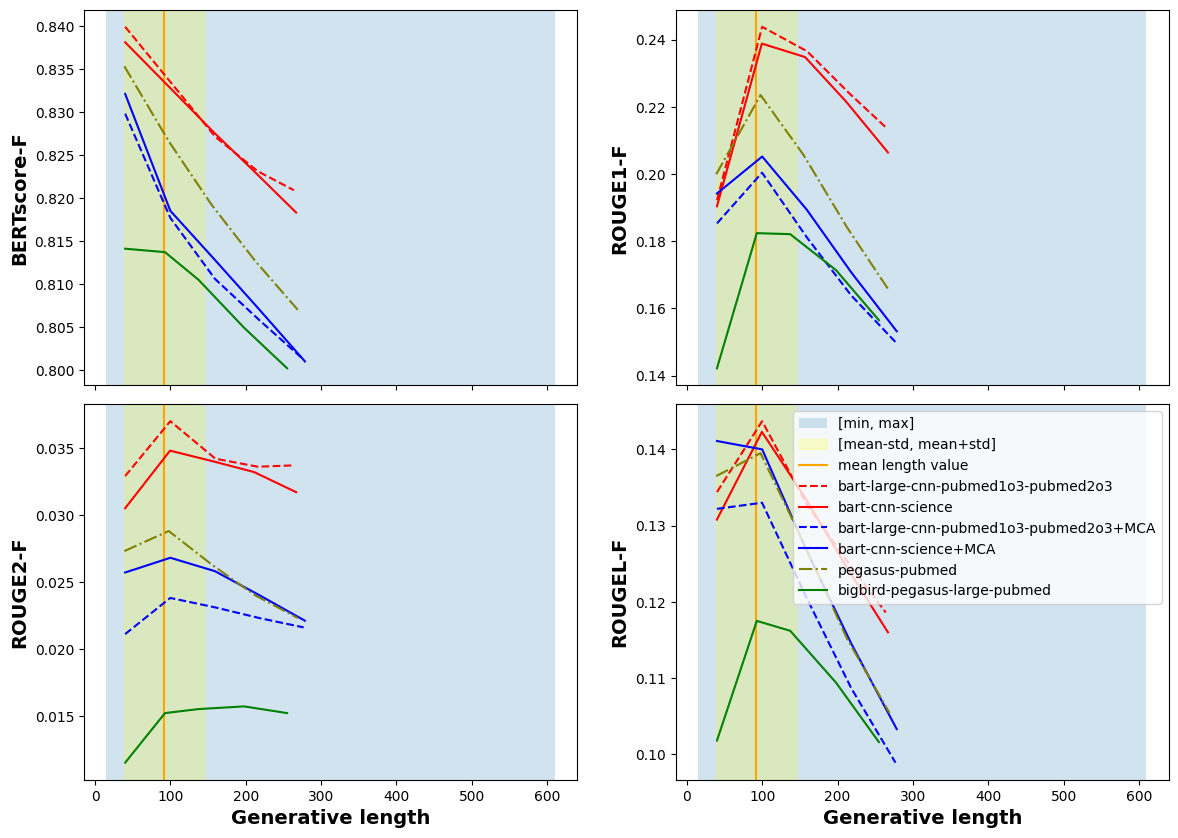

In [43]:
%matplotlib inline
# !mkdir ./documents
import numpy as np
import matplotlib.pyplot as plt
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,10), sharex=True)
plt.subplots_adjust(hspace=0.05)  # Adjust vertical spacing
plt.subplots_adjust(wspace=0.2)  # Adjust horizontal spacing
lines, labels = [], []

colors = {
    'bart': 'red',
    'pegasus': 'olive',
    'bigbird': 'green',
    'MCA': 'blue',
}
aspect_map = {
    'avg-bert-f1': 'BERTscore-F', 
    'avg-rouge1-fmeasure': 'ROUGE1-F', 
    'avg-rouge2-fmeasure': 'ROUGE2-F',
    'avg-rougeL-fmeasure': 'ROUGEL-F',
}

for aspect, ax in zip(['avg-bert-f1', 'avg-rouge1-fmeasure', 'avg-rouge2-fmeasure', 'avg-rougeL-fmeasure'],
                      [ax1, ax2, ax3, ax4]):
    ax.axvspan(min_length, max_length, alpha=0.2, label='[min, max]')
    ax.axvspan(mean_length-std, mean_length+std, alpha=0.2, label='[mean-std, mean+std]', color='yellow')
    ax.axvline(mean_length, color='orange', label='mean length value')
    ax.set(ylabel=aspect_map[aspect])
    for model_name, df in statistics_by_model.items():
        color = None
        for k in colors:
            if k in model_name:
                color = colors[k]
        if '2o3' in model_name:
            ax.plot(df['gen_len'], df[aspect], '--', label=model_name, color=color)
        elif 'pegasus' in model_name and 'bigbird' not in model_name:
            ax.plot(df['gen_len'], df[aspect], '-.', label=model_name, color=color)
        else:
            ax.plot(df['gen_len'], df[aspect], label=model_name, color=color)

ax4.legend()
ax3.set(xlabel='Generative length')
ax4.set(xlabel='Generative length')
fig.savefig(f'./documents/multi-range-mslr-cochrane-avg.png')
fig.savefig(f'./documents/multi-range-mslr-cochran-avg.pdf')


## Fixed-length setting summary
### Summary table (In the order R2F decreased)

In [19]:
import pandas as pd

df_fixed = pd.read_csv(f'./documents/MLSR-cochrane-full-fixed-setting.csv')
df_fixed.rename(columns={'Unnamed: 0': 'Model'}, inplace=True)
df_fixed['Model'] = df_fixed['Model'].map(lambda x: name_map[x] if x in name_map else x)
df_fixed.sort_values('avg-rouge2-fmeasure', ascending=False)

,Model,expected_len,avg-rouge1-precision,avg-rouge1-recall,avg-rouge1-fmeasure,avg-rouge2-precision,avg-rouge2-recall,avg-rouge2-fmeasure,avg-rougeL-precision,avg-rougeL-recall,avg-rougeL-fmeasure,avg-bert-precision,avg-bert-recall,avg-bert-f1,gen_len,overflow_ratio
0,bart-large-cnn-pubmed1o3-pubmed2o3,91.4681,0.2026,0.3325,0.2365,0.0291,0.0489,0.0342,0.1120,0.1917,0.1327,0.8072,0.8482,0.8271,159.6745,0.4275
1,bart-cnn-science,91.4681,0.2025,0.3284,0.2348,0.0292,0.0486,0.0340,0.1138,0.1920,0.1337,0.8076,0.8491,0.8277,156.8447,0.4275
4,pegasus-pubmed,85.3660,0.1790,0.2837,0.2057,0.0224,0.0374,0.0263,0.1094,0.1814,0.1278,0.7993,0.8404,0.8192,154.7489,0.3811
3,bart-cnn-science+MCA,91.4681,0.1599,0.2765,0.1894,0.0217,0.0382,0.0258,0.1050,0.1910,0.1267,0.8018,0.8244,0.8128,159.1000,0.0000
2,bart-large-cnn-pubmed1o3-pubmed2o3+MCA,91.4681,0.1511,0.2706,0.1812,0.0192,0.0347,0.0231,0.0988,0.1865,0.1205,0.7997,0.8223,0.8106,159.0638,0.0000
5,bigbird-pegasus-large-pubmed,85.3660,0.1669,0.2379,0.1821,0.0139,0.0207,0.0155,0.1051,0.1550,0.1162,0.7942,0.8278,0.8105,137.1766,0.0845


## Adaptive-length setting summary
### Summary table (In the order R2F decreased)

In [20]:
import pandas as pd

df_fixed = pd.read_csv(f'./documents/MLSR-cochrane-full-adaptive-setting.csv')
df_fixed.rename(columns={'Unnamed: 0': 'Model'}, inplace=True)
df_fixed['Model'] = df_fixed['Model'].map(lambda x: name_map[x] if x in name_map else x)
df_fixed.sort_values('avg-rouge2-fmeasure', ascending=False)

,Model,expected_len,avg-rouge1-precision,avg-rouge1-recall,avg-rouge1-fmeasure,avg-rouge2-precision,avg-rouge2-recall,avg-rouge2-fmeasure,avg-rougeL-precision,avg-rougeL-recall,avg-rougeL-fmeasure,avg-bert-precision,avg-bert-recall,avg-bert-f1,gen_len,overflow_ratio
0,bart-large-cnn-pubmed1o3-pubmed2o3,91.4681,0.2031,0.3323,0.2367,0.0292,0.0488,0.0343,0.1123,0.1916,0.1328,0.8073,0.8482,0.8271,159.3681,0.4275
1,bart-cnn-science,91.4681,0.2041,0.3280,0.2352,0.0298,0.0485,0.0342,0.1148,0.1918,0.1340,0.8081,0.8491,0.8280,155.9851,0.4275
4,pegasus-pubmed,85.3660,0.1823,0.2808,0.2061,0.0229,0.0370,0.0263,0.1115,0.1795,0.1280,0.8003,0.8405,0.8198,151.5936,0.3811
3,bart-cnn-science+MCA,91.4681,0.1599,0.2765,0.1894,0.0217,0.0382,0.0258,0.1050,0.1910,0.1267,0.8018,0.8244,0.8128,159.1000,0.0000
2,bart-large-cnn-pubmed1o3-pubmed2o3+MCA,91.4681,0.1511,0.2705,0.1813,0.0192,0.0347,0.0231,0.0988,0.1864,0.1206,0.7998,0.8223,0.8107,158.9085,0.0000
5,bigbird-pegasus-large-pubmed,85.3660,0.1754,0.2216,0.1793,0.0146,0.0195,0.0155,0.1118,0.1446,0.1150,0.7974,0.8276,0.8120,124.1532,0.0845
